# Tutorial for NIRCam post-pipeline contrast analyses using spaceKLIP

In this notebook we will analyze the NIRCam coronagraphy data on HIP 65426 b 
from the JWST ERS program on Direct Observations of Exoplanetary Systems, program 1386. 


<div class="alert alert-warning">
<b>Prerequisite:</b> This notebook assumes you have already ran the "Tutorial for NIRCam data reductions" notebook. The output files  must be present from that reduction to be analyzed in this notebook.

</div>

## Table of Contents:
* [Setup and imports](#Setup-and-imports)
* [Prepare for Contrast Calculations](#Prepare-for-Contrast-Calculations)
* [Compute Raw Contrasts](#Compute-Raw-Contrasts)
* [Compute Calibrated Contrasts](#Compute-Calibrated-Contrasts)
* [Extract measurements of the planet](#Extract-measurements-of-the-planet)


## Setup and imports

In [1]:
import os
import pdb
import sys
import glob

import numpy as np
import astropy.io.fits as fits
import astropy.table

import matplotlib.pyplot as plt
import matplotlib

import spaceKLIP

Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
data_root = 'data_nircam_hd65426'

## Prepare for Contrast Calculations

### Re-read level 3 outputs into database 
Read in output files produced in the NIRCam coronagraph data reduction notebook. 


For the purposes of this example, we restrict to just running on one filter. This suffices for an example, and is faster than running for all filters. 

In [4]:
filt = 'F444W'

In [5]:
input_dir = os.path.join(data_root, 'klipsub')
    
fitsfiles = sorted(glob.glob(os.path.join(input_dir, f"*{filt}*KLmodes-all.fits")))

database = spaceKLIP.database.Database(output_dir=data_root)
database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP  TARGPROP INSTRUME DETECTOR FILTER      CWAVEL          DWAVEL     ... NINTS  EFFINTTM   SUBARRAY   PIXSCALE    MODE  ANNULI SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- --------- -------- -------- ------ --------------- --------------- ... ----- --------- ----------- ---------- ------- ------ -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST HIP-65426   NIRCAM NRCALONG  F444W 4.4393515120525 1.0676002928393 ...     4 307.88352 SUB320A335R 0.06247899 ADI+RDI      1        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST HIP-65426   NIRCAM NRCALONG  F444W 4.4393515120525 1.0676002928393 ...     4 307.88352 SUB320A335R 0.06247899 ADI+RDI      5        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST 


### Preparation: Stellar Photometry Model

A model of the target star is needed to compute its flux in the observational filters, and thereby produce a reference point from which to determine our contrast performance. This requires an input that gives either **(a)** the host star photometry, formatted as a [Vizier](http://vizier.cds.unistra.fr) VOTable, or **(b)** a simple text file with two columns giving wavelenth in microns and flux in Jy.


If you need to obtain you own version of option **(a)**, head to Vizier's [Photometry Viewer](http://vizier.cds.unistra.fr/vizier/sed/) and input your target of interest. However, exercise caution as this search can introduce spurious photometry measurements from nearby sources, which are realised as sharp variations in flux that do not agree with the expected profile of the targets spectral energy distribution. You may need to clean the obtained data by reducing the search radius, or manually removing individual points using the checkboxes in the table at the bottom. Once you are happy, click \"Download Data\" to obtain a VOTable that can be directly ingested into spaceKLIP. Option **(b)** could be instead be produced, for instance, from fitting a scaled version of a stellar atmosphere model to available photometry.

We provide here examples of both kinds of file, provided by Aarynn Carter. _Only one is needed; we provide both purely as examples._

In [6]:
star_photometry_vot = 'HIP65426.vot'
star_photometry_txt = 'HIP65426A_sdf_phoenix_m+modbb_disk_r.txt'
star_spectral_type = 'A2V'

In [7]:
import astropy

# Read in VOT version
vot_version = astropy.table.Table.read(star_photometry_vot)

# convert from freq to wl, just for plotting below.
vot_version['wavelength'] = (astropy.constants.c /  vot_version['sed_freq']).to(astropy.units.micron)

# Read in TXT version
txt_version = astropy.table.Table.read(star_photometry_txt,
                                       format='ascii',
                                       names=['wavelength', 'flux'])
txt_version.columns['wavelength'].unit = astropy.units.micron
txt_version.columns['flux'].unit = astropy.units.Jansky

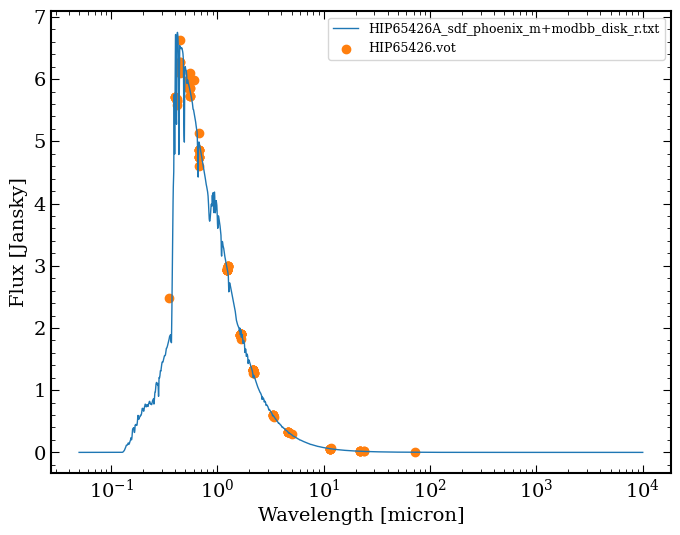

In [8]:
# plot, to show the two models are consistent

plt.semilogx(txt_version['wavelength'], txt_version['flux'], label='HIP65426A_sdf_phoenix_m+modbb_disk_r.txt',)
plt.scatter(vot_version['wavelength'], vot_version['sed_flux'], label='HIP65426.vot', color='C1')

plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [Jansky]")
plt.legend(fontsize=9)


### Prior knowledge about the companion. 

In this case, we are characterizing a known companion, that we already know the expected location of. 
This means that we can and should mask that companion out of the contrast calculations. 


Using [whereistheplanet.com](https://whereistheplanet.com) for the date of observations, 2022 Aug 15:
```
RA Offset = 416.618 +/- 0.045 mas 
Dec Offset = -703.443 +/- 0.051 mas 
Separation = 817.558 +/- 0.036 mas 
PA = 149.364 +/- 0.004 deg 
Reference: Blunt et al. 2023
```

Measuring the companion starts from an estimated contrast, which can be approximate and based on prior knowledge. 

In [9]:
comp_dra = 0.416
comp_ddec = -0.703
comp_est_contrast = 1e-4

### Set up Analysis Tools

We initialize the AnalysisTools class and provide it the database of files to be analyzed. 

In [10]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(database)


## Compute Raw Contrasts

This iterates over all filters and datasets in the database. 

The 'raw' contrast is computed from the standard deviation in each radial bin. A scaling factor is applied at each location in the 2D image to account for the coronagraph mask throughput, which varies as a function of position. 


If you have reduced the raw contrasts using multiple strategies (e.g. ADI, RDI, ADI+RDI, and/or different numbers of annuli for the optimization regions), then the raw contrast calculation will be repeated for each of those outputs. 

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
Contrast results and plots saved to data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy, data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmo

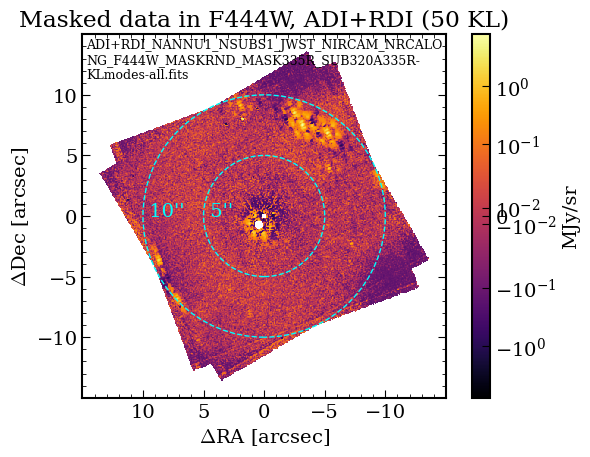

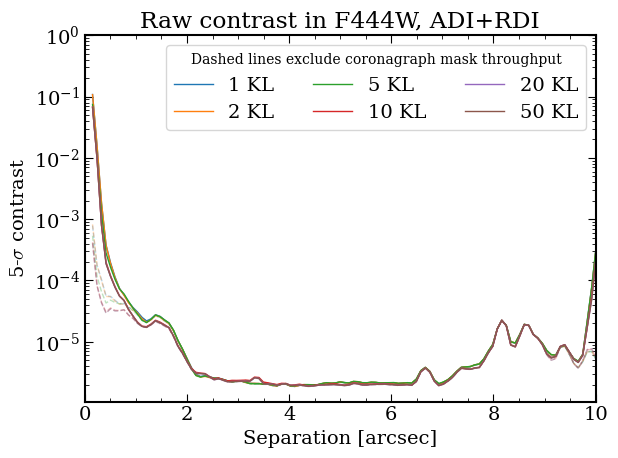

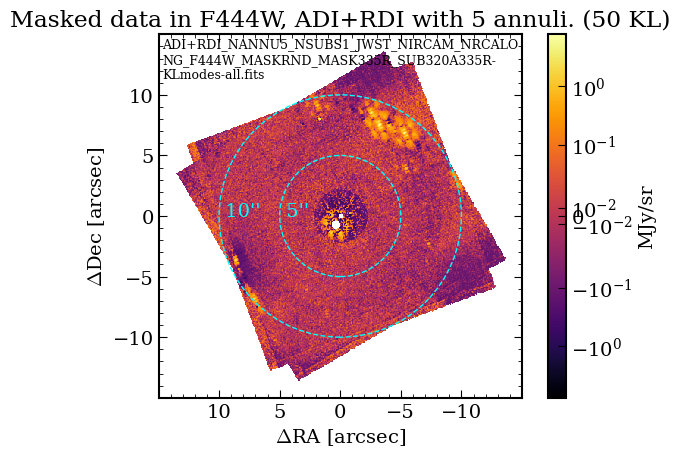

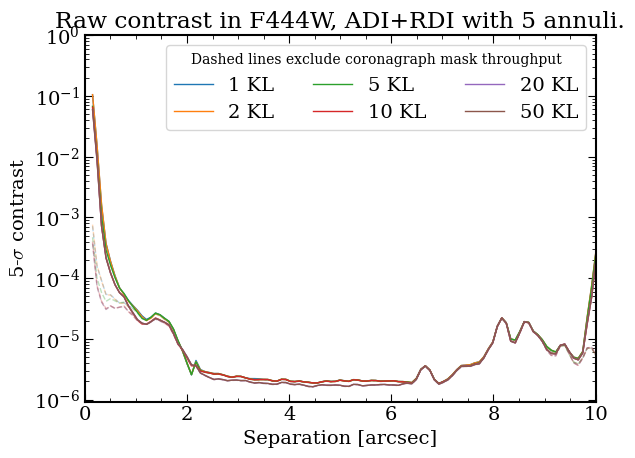

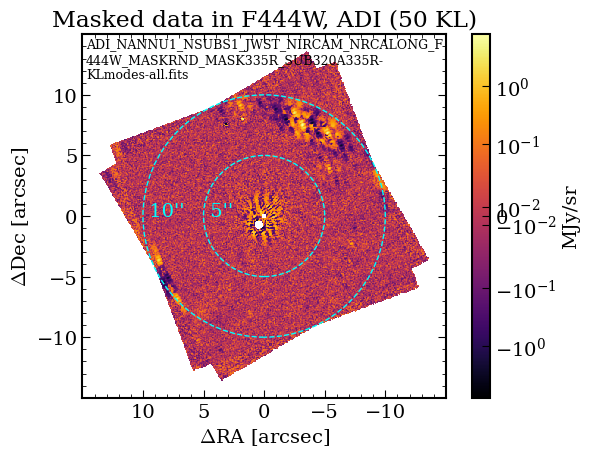

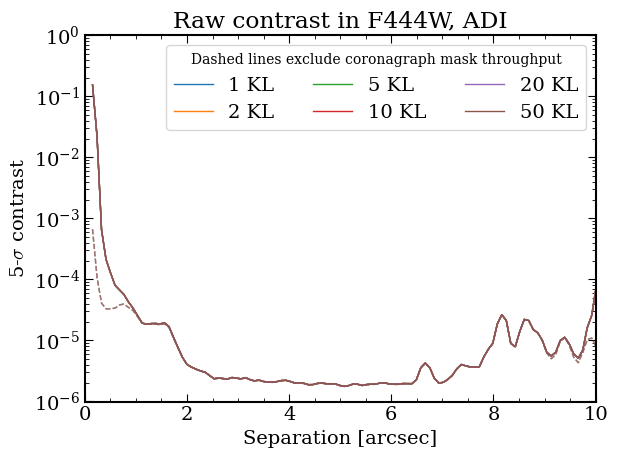

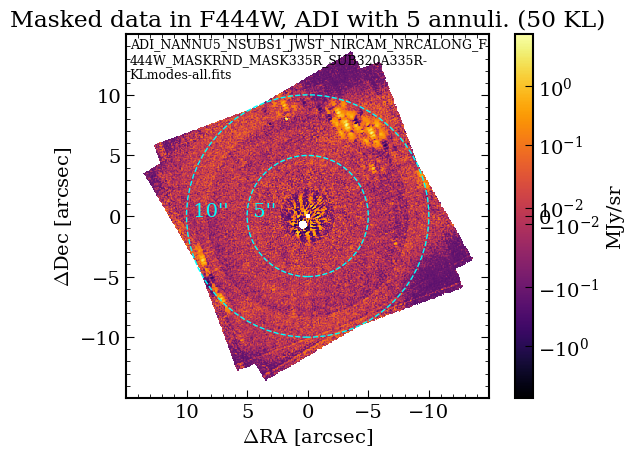

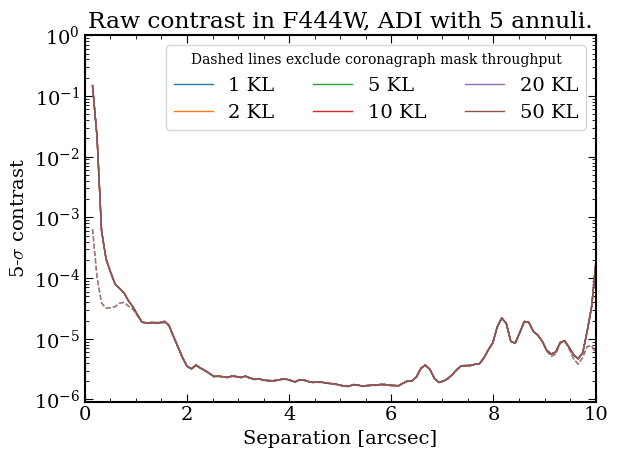

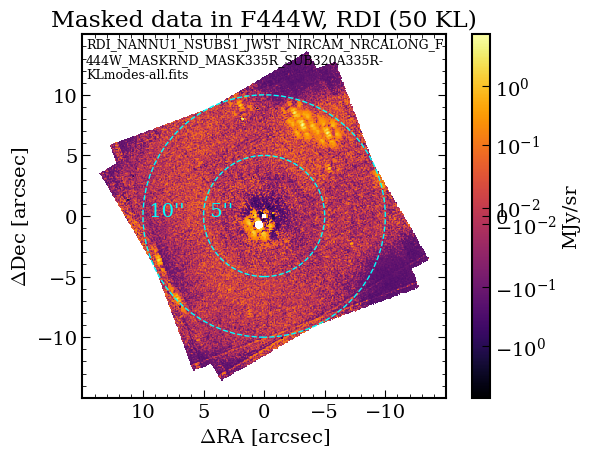

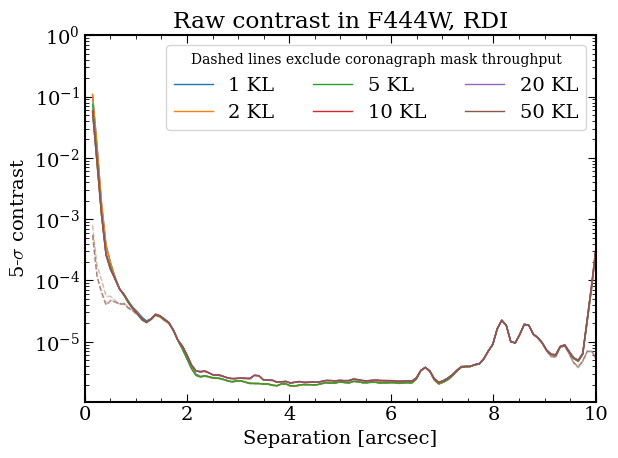

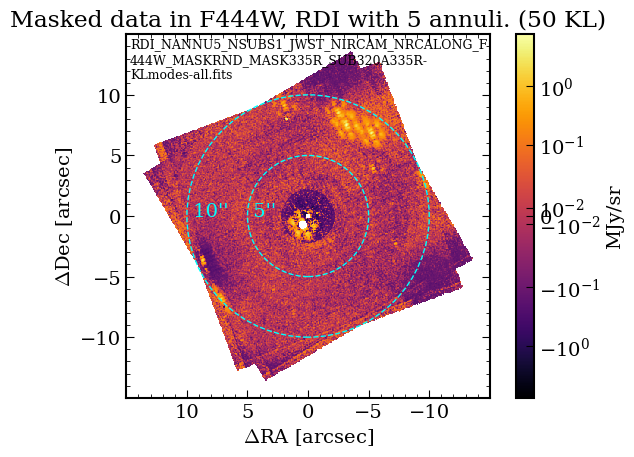

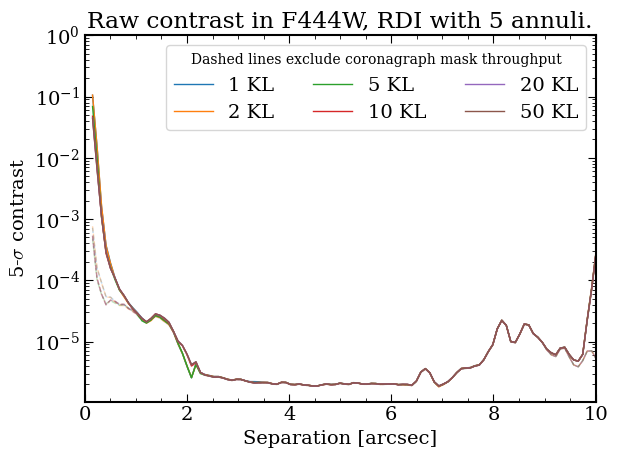

In [11]:
# Compute raw contrast.
analysistools.raw_contrast(star_photometry_txt,
                           spectral_type=star_spectral_type,
                           companions=[[comp_dra, comp_ddec, 2.]],
                           subdir='rawcon')


The output of these is a large set of files within the `rawcon` subdir of the data directory. This includes PDFs showing the reduced images, and plots of contrast, and also saved contrast curves. 

Raw contrast curves are saved as `.npy` numpy data dump files.  We plan to migrate to saving as astropy ECSV format text files, for easy use with astropy.table. 

In [12]:
!ls data_nircam_hd65426/rawcon/*npy

data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons_mask.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons_mask.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy
data_nircam_hd65426/rawcon/ADI+RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLm

Text(0.5, 1.0, 'Raw Contrast in F300M')

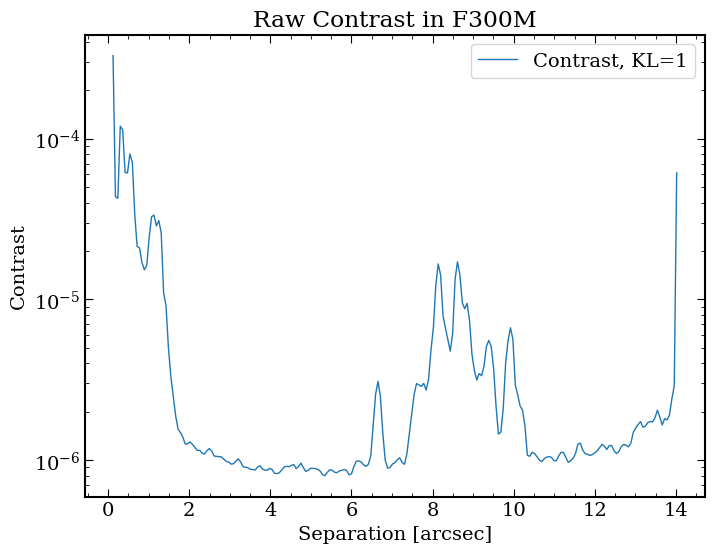

In [13]:
cons = np.load('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps = np.load('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')

# eventually we will switch to saving as astropy tables. 
#rawcon = astropy.table.Table.read('data_nircam_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F250M_MASKRND_MASKA335R_SUB320A335R-KLmodes-all_contrast.ecsv')

plt.semilogy(seps[0], cons[0], label='Contrast, KL=1')
plt.xlabel("Separation [arcsec]")
plt.ylabel("Contrast")
plt.legend()
plt.title("Raw Contrast in F300M")


## Compute Calibrated Contrasts

The 'calibrated' contrast uses injections of simulated companions to calibrate algorithm throughput, i.e. oversubtraction and self-subtraction of companions during the PSF subtraction. 

This starts from the output of the raw contrast calculation; you must do the raw contrast calculation first. 

This function performs injection and retrieval of companion at specified separations and position angles, and applies the retrieved scale factors to calibrate the contrast curves. Again, this will be iteratively performed for each PSF subtractions strategy used (ADI, RDI, ADI+RDI, and different numbers of KL modes for each).


This takes a little while to run, more or less depending on the number of injected companions and number of subtraction strategies used. Progress bars provide status while it runs.  

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI+RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/ADI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] Analyzing file data_nircam_hd65426/klipsub/RDI_NANNU5_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> All 3 source positions suitable for injection.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

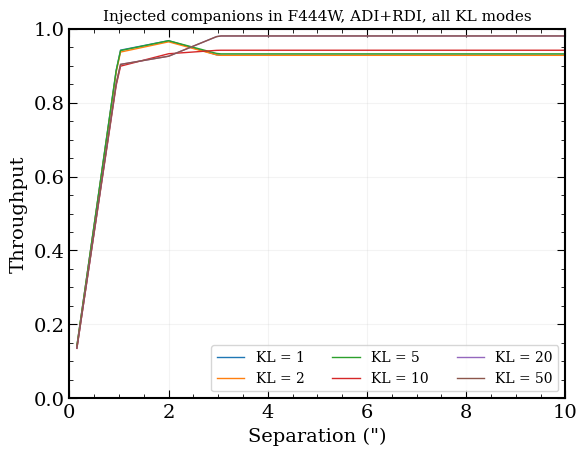

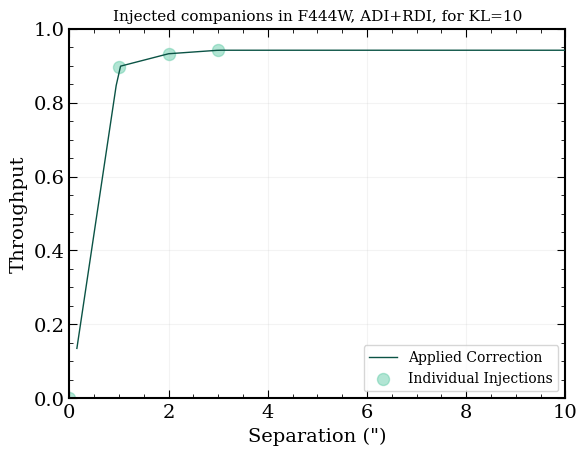

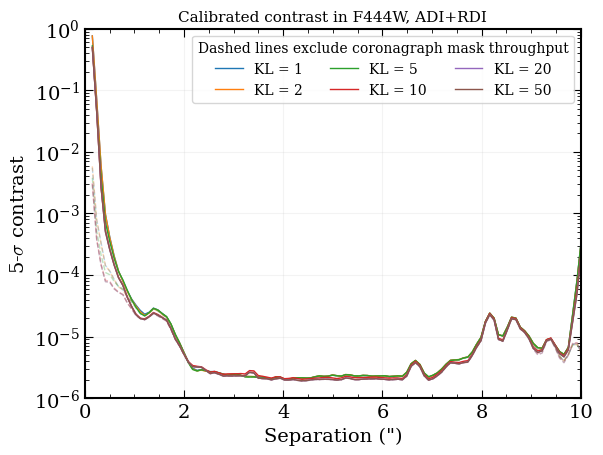

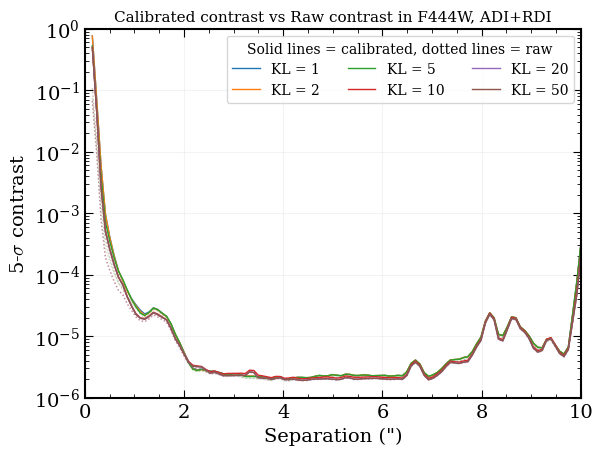

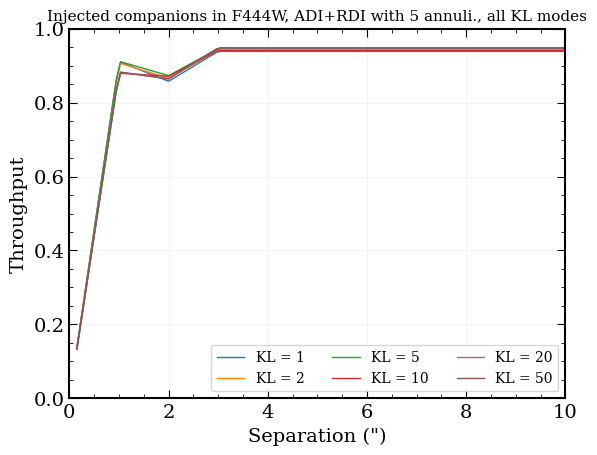

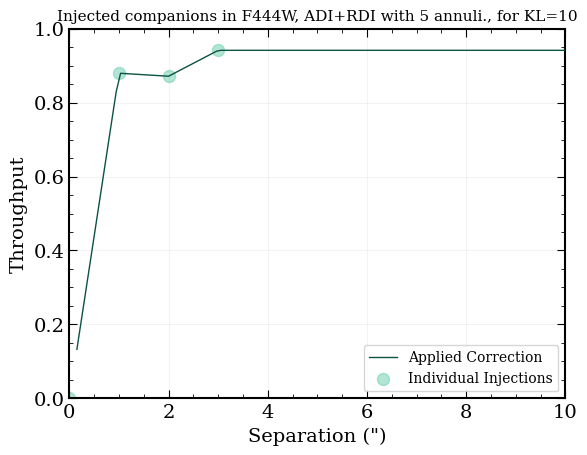

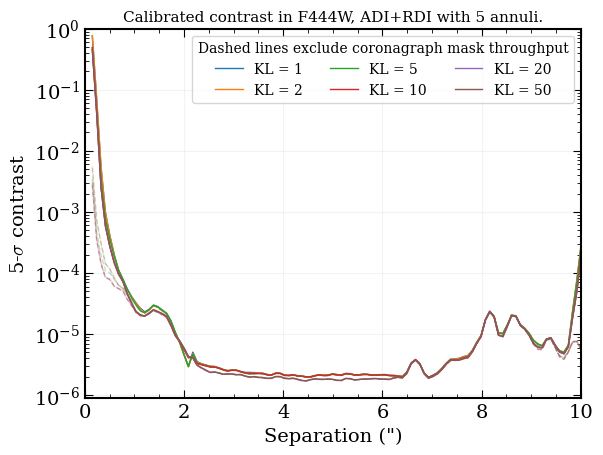

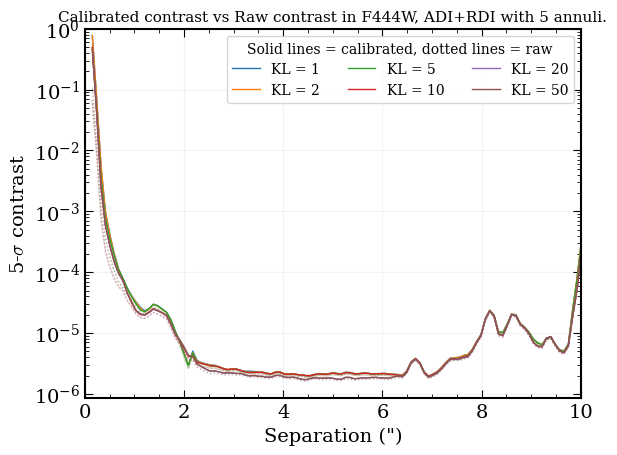

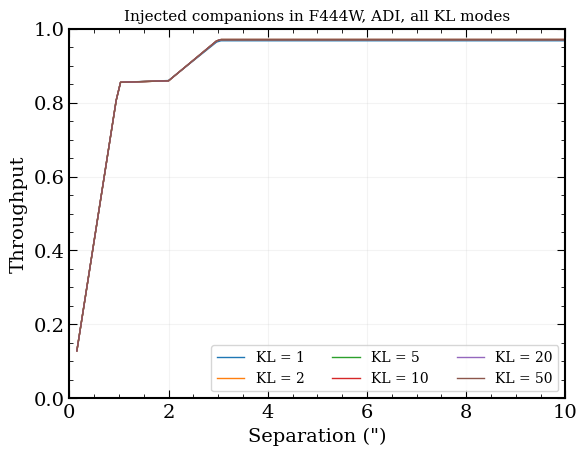

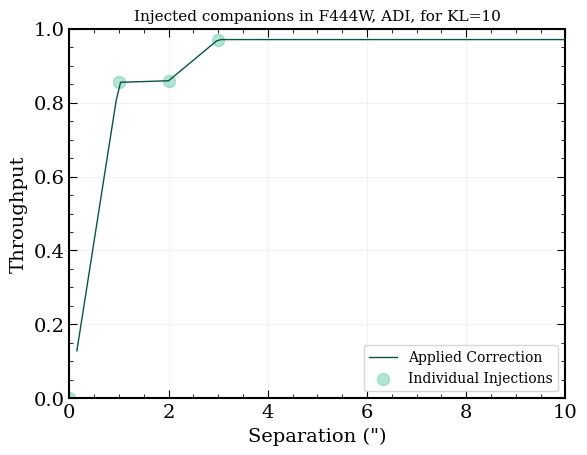

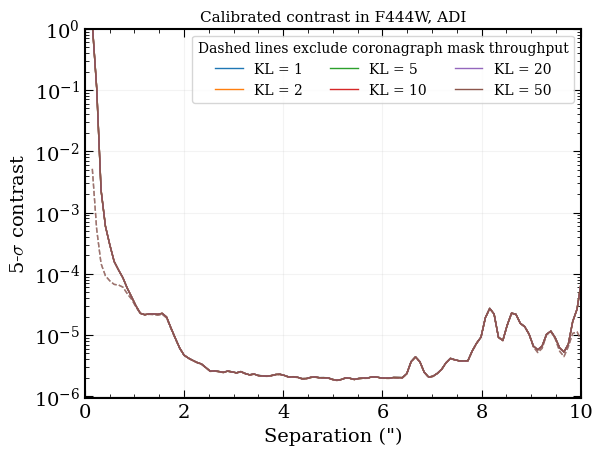

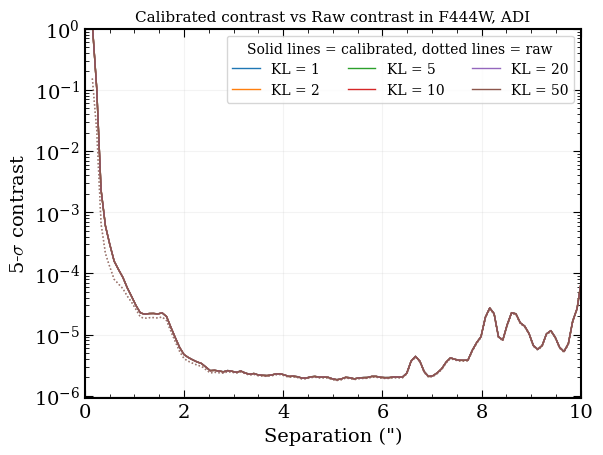

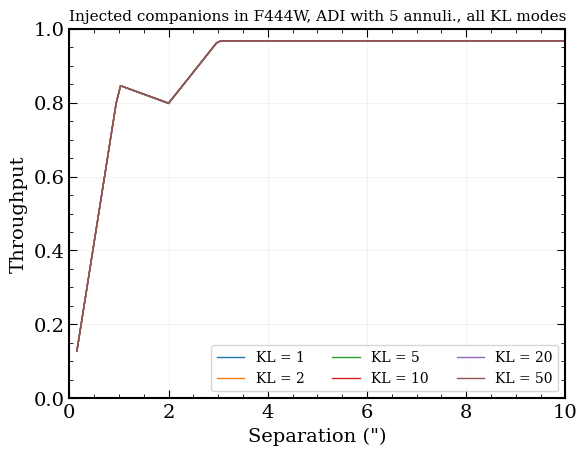

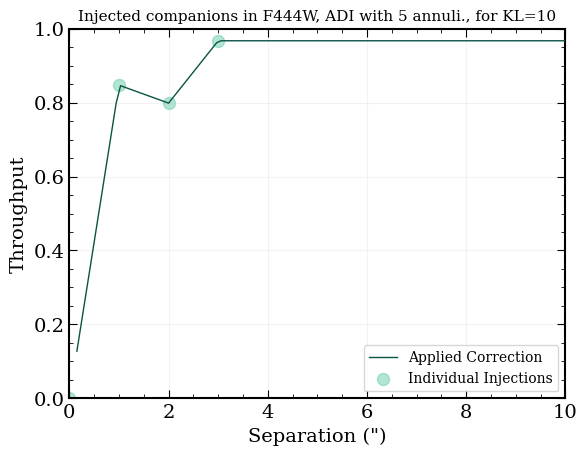

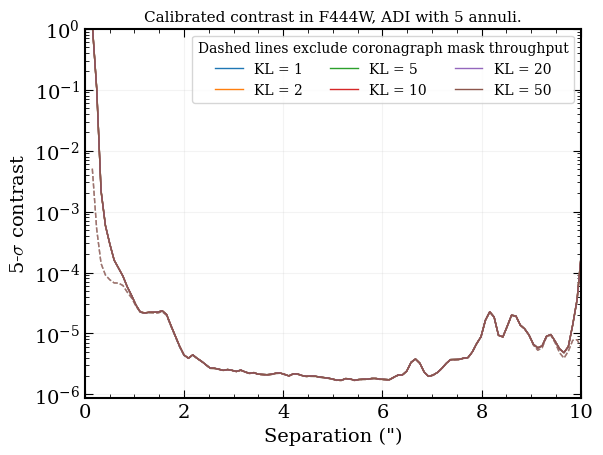

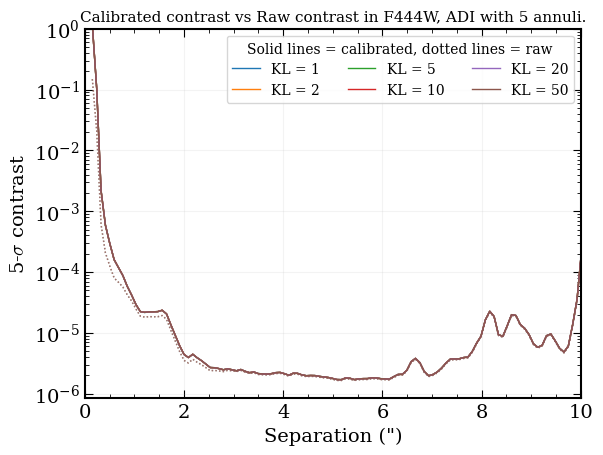

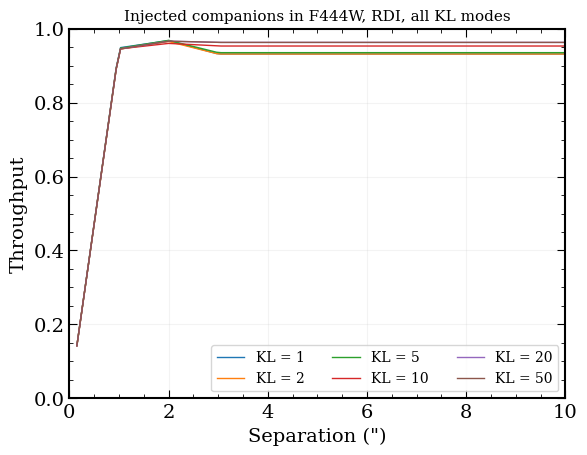

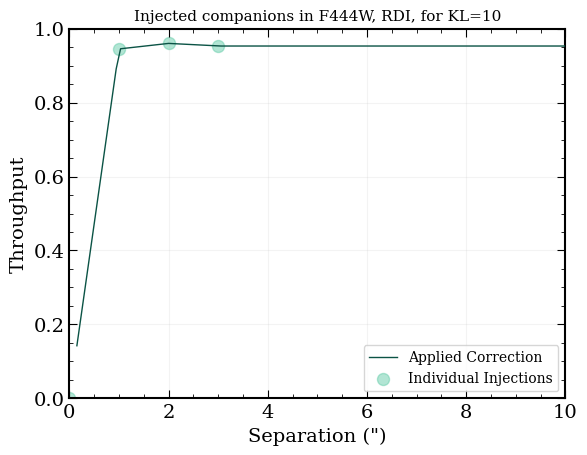

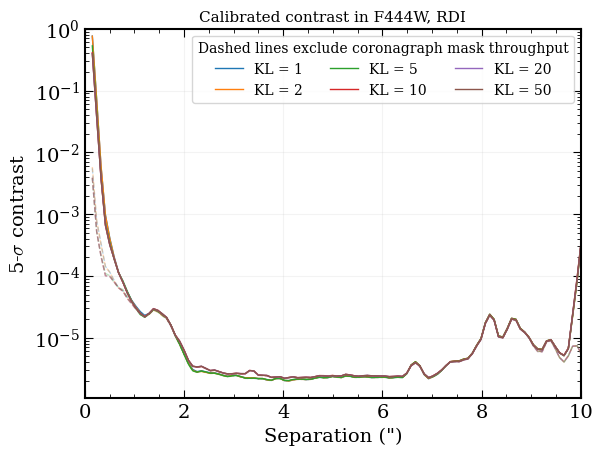

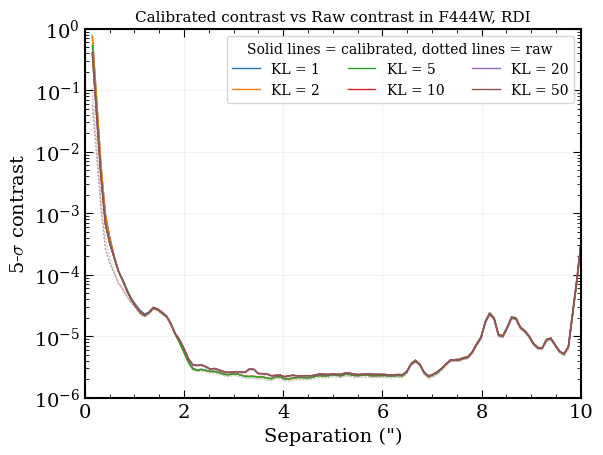

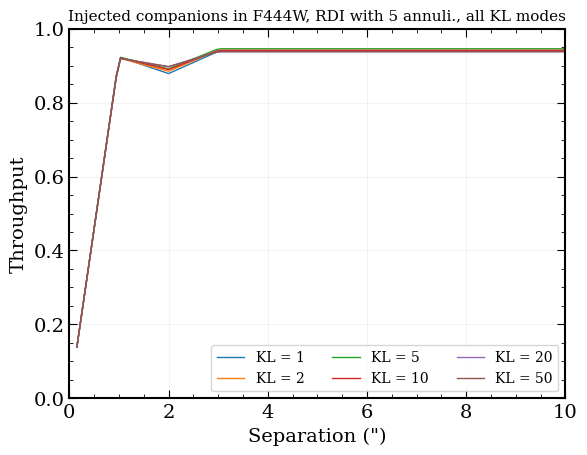

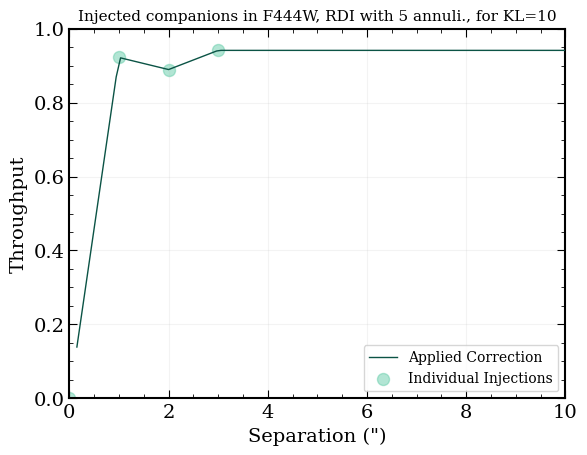

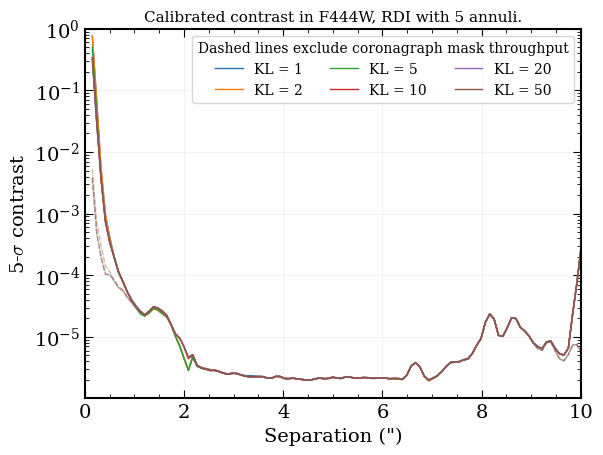

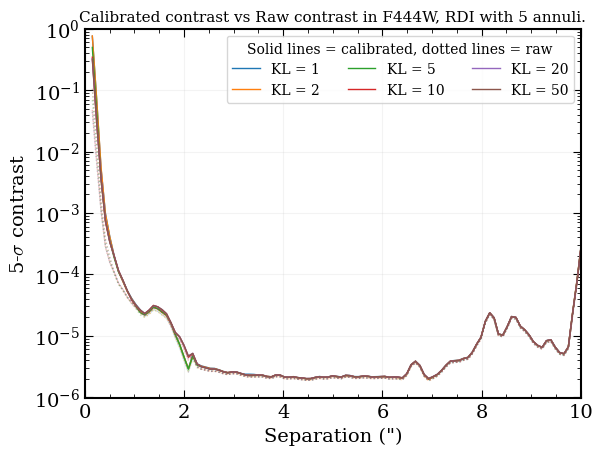

In [14]:
#Compute calibrated contrast.
analysistools.calibrate_contrast(rawcon_subdir='rawcon', #Directory raw contrast was saved to
                                 companions=[[comp_dra, comp_ddec, 2.]],  #[RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)] for companions to avoid injecting too close
                                 injection_seps=[1, 2, 3], # Separations to inject and recover companions (arcsec), can also be 'default'
                                 injection_pas=[45], # PAs to inject and recover companions (degrees), can also be 'default'
                                 injection_flux_sigma=20, #N sigma flux of injected companion relative to contrast of median KL mode subtraction (default 20)
                                 multi_injection_spacing=None, #Spacing between injected companion, None = 1 companion per injection+recovery.
                                 use_saved=False) # whether to run the companion injection, or load saved files. Useful for debugging / changing plots / sharing files.

Similar to the raw contrast step, the outputs are saved as a large series of PDF plots and .npy saved arrays, in a `calcon` subdirectory. 
We intend to migrate the saved data to astropy Table format. 

## Extract measurements of the planet


<font color='red'> The below is not yet fully working. To be debugged in a future PR. Contact Jens or Marshall for more info.</font>

We also need to have a model for the stellar photometry for this step. We reuse the same file as above. 

This step also requires an uncertainty for the stellar photometry, parameterized `mstar_err`. This can be either a simple scalar estimate, like 0.05, or a dictionary giving uncertainty per JWST filter. 

In [15]:
mstar_err = {'F250M': 0.054,    # These values are taken from... where?
             'F300M': 0.046,
             'F356M': 0.048,
             'F410M': 0.051,
             'F444W': 0.054,
             'F1140C': 0.038,
             'F1550C': 0.072}

In [16]:
# Extract companions.
analysistools.extract_companions(companions=[[comp_dra, comp_ddec, 1e-4]],  # delta RA, delta Dec, estimated contrast
                                 starfile=star_photometry_vot,
                                 mstar_err=0.,
                                 spectral_type=star_spectral_type,
                                 klmode='max',
                                 date='auto',
                                 use_fm_psf=True,
                                 highpass=False,
                                 fitmethod='mcmc',
                                 fitkernel='diag',
                                 subtract=True,
                                 inject=False,
                                 #remove_background=False,
                                 #save_preklip=False,
                                 overwrite=True,
                                 subdir='companions')

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 85656.89030495791 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


  0%|          | 0/1 [00:00<?, ?it/s]

[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 85097.68681261895 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior


[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours


MCMC sampler has finished


SameFileError: 'data_nircam_hd65426/companions/KL50/C1/PREKLIP/jw01386002001_0310a_00001_nrcalong_calints.fits' and 'data_nircam_hd65426/companions/KL50/C1/PREKLIP/jw01386002001_0310a_00001_nrcalong_calints.fits' are the same file